legi:

# SLT-CE-3: Histogram Clustering

In this coding exercise, you will segment an image with histogram clustering (HC). You will implement two different methods: maximum a posterior probability (MAP) and deterministic annealing (DA) for predicting the cluster membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981 

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt21_lecture05.pdf

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf, chapter 2.7

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
!pip install seaborn

In [2]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread
import seaborn as sn 
from scipy.optimize import linear_sum_assignment

In [3]:
from time import time
import pandas as pd
from tqdm.notebook import tqdm


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Texture and corresponding label map
(This texture is used to fit your model.)

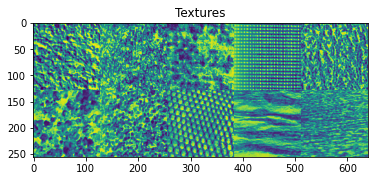

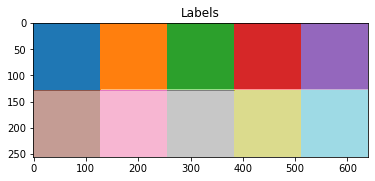

In [4]:
texture = imread("texture.png")

patch_grid_shape = (2, 5)
patch_shape = (128, 128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

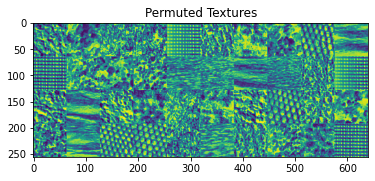

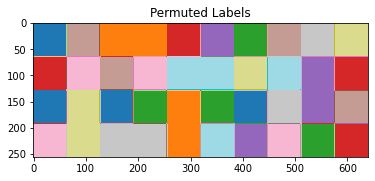

9.0


In [5]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i // 2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape) * np.array(perm_patch_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape) * np.array(perm_patch_shape)

    perm_texture[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = texture[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

    perm_label_map[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = label_map[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()
print(np.max(perm_label_map))

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both: maximum a posteriori probability estimation (MAP) and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> looks for the case of DA (using the notation of reference [1]).<br>
Hint: try to derive $\hat P(y|c)$ from $\hat P(c|x)$ and use the maximum entropy principle to find $\hat P(c|x)$.
</p>

### Parameter Estimation for MAP
Prior distribution: $P(c,\theta|\mathbf{n})\propto P(c)\prod_{x\in\mathcal{X}}\prod_{y\in\mathcal{Y}}(P(x)P(x|c(x)))^{n(x,y)}$

Corresponding log-posterior distribution: $L(c,\theta;\mathbf{n})=\sum_{x\in\mathcal{X}} n(x)\left[ \sum_{y\in\mathcal{Y}} \hat P(y|x)\log P(y|c(x)) + logP(x) \right] + logP(c)$

Result of maximizing over this prior: $$\hat P(y|c) = \sum_{x:\hat c(x) = c} \frac{n(x)}{\sum_{x:\hat c(x) = c} n(x')\hat P(y|x)}$$

### Parameter Estimation for DA
It has been proven that the KL-divergence as a distortion measure follows from the likelihood principle.

In the lecture the following cost funciton, based on the likelihood of the data, was derived:
$$\mathcal{R^{hc}}(c,q)= \frac{l}{n}\sum_{i\leq n}D_{KL}\left(\hat P(\cdot |x_i)||Q(\cdot |c(x_i))\right),$$
where $\hat P(y|x_i) = \frac{n(x,y)}{n(x)} = \frac{n(x,y)}{\sum_{y\in \mathcal{Y}}n(x,y)}$ is the emperical distribution over $\mathcal{Y}$ for $x$, and $Q(y_j|c(x_i))=\frac{\sum_i \hat P (y_j|x_j) P_{x_i c(x_i)}}{P_{x_i  c(x_i)}}$.

Minimizing over this cost function then leads to the following equation for probabilistic assignment:
$$P(c|\theta, X) = \prod_{i\leq n} \frac{\exp (-D^{KL}(\hat P (\cdot |x_i)||Q(\cdot | c(x_i)))/T)}{\sum_\nu \exp (-D^{KL}(\hat P (\cdot |x_i)||Q(\cdot | \nu))/T)}.$$

Following the maximum entropy principle, the following (non-closed-form-) solution can be derived.

From this derivation it fallows that in the case of DA, equation (5) becomes $$\hat{P}(y|c)=\frac{\sum_i P(c|\theta,x_i)\cdot \hat P(y|x_i)}{\sum_i P(c|\theta,x_i)}$$


Despite that this is not a closed form solution, it can be solved with the following update formula:
$$P^{(0)}(y|c)\leftarrow \$ $$
$$P^{(t+1)}(y|c)\leftarrow \frac{\sum_i P^{(t)}(c|\theta,x_i) \hat P(y|x_i)}{\sum_i P^{(t)}(c|\theta,x_i)}$$where
$$P^{(t)}(c|\theta,x_i)=\frac{\exp \left( -\frac{1}{T}D_{KL}\left[ \hat P(\cdot| x_i ) || P^{(t)} (\cdot | c(x_i)) \right] \right)}{\sum_\nu \exp \left(-\frac{1}{T}D^{KL}\left[\hat P (\cdot |x_i)||P^{(t)}(\cdot | \nu)\right]\right)}$$

In [6]:
from math import ceil

In [7]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=64, window_size=7, random_state=42, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins =n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        # Add more parameters, if necessary.
        
        self.P_y_given_x_emperical = None
        self.X_patched = list()
        self.X_patched_bins_flat = None
        
        self.centroids = np.full((n_clusters, n_bins), 1/n_clusters)
        self.p_cluster = None
        self.p_cluster_if = None
        self.class_opt = None
        self.emp_y_given_x = None
        
        self.p_x = None
        self.n_x = []
        self.hist_numbering = None
    """def get_patch(self, X, patch_index):
        (i,j) = patch_index
        
        if j == 0: p_hor = 0
        else: p_hor = 0
        if i == 0: p_ver = 0
        else: p_ver = 0
        
        vertical_span = (i+1)*self.window_size-p_ver
        horizontal_span = (j+1)*self.window_size -p_hor
        if j == ceil(X.shape[1]/7)-1 and not j == 0: horizontal_span = None
            
        if i == ceil(X.shape[0]/7)-1 and not i == 0: vertical_span = None
        patch = X[(i*self.window_size)-p_ver:vertical_span, (j*self.window_size)-p_hor:horizontal_span]"""
    def get_patch(self, X, patch_index):
        (i,j) = patch_index

        if i < int(self.window_size/2):
            ub = 0
        else:
            ub = i-int(self.window_size/2)
        if i > X.shape[0]-int(self.window_size/2)-1:
            db = None
        else:
            db = i + int(self.window_size/2)+1
        if j < int(self.window_size/2):
            lb = 0
        else:
            lb = j-int(self.window_size/2)
        if j > X.shape[1]-int(self.window_size/2)-1:
            rb = None
        else:
            rb = j + int(self.window_size/2)+1
            

        patch = X[ub:db,lb:rb]
        

        return patch
    def convert_patch(self,X, patch_index, cluster):
        (i,j) = patch_index

        if i < int(self.window_size/2):
            ub = 0
        else:
            ub = i-int(self.window_size/2)
        if i > X.shape[0]-int(self.window_size/2)-1:
            db = None
        else:
            db = i + int(self.window_size/2)+1
        if j < int(self.window_size/2):
            lb = 0
        else:
            lb = j-int(self.window_size/2)
        if j > X.shape[1]-int(self.window_size/2)-1:
            rb = None
        else:
            rb = j + int(self.window_size/2)+1
        
        
        
        patch = X[ub:db,lb:rb] = cluster
        return X
            
    
    def get_centroids(self,class_opt):
        centroids = np.zeros(self.centroids.shape)
        for c_i in range(self.n_clusters):
            """n_x_at_x = np.zeros(len(self.n_x))
            emp_y_given_x_at_x = np.zeros(self.emp_y_given_x.shape)
            s=0"""
            x_index = []
            time1=time()
            for x_i in range(self.class_opt.shape[0]):
                if class_opt[x_i] == c_i:
                    x_index.append(x_i)

            time2=time()

            x_index = np.array(x_index)
            n_x_at_x = np.array(self.n_x)[x_index[:None]]
            emp_y_given_x_at_x = self.emp_y_given_x[x_index[:,None], :][:,0,:]
            sum_ =np.sum(n_x_at_x.reshape((-1,1))*emp_y_given_x_at_x, axis=0)
            div = np.sum(n_x_at_x)
            if div == 0:
                centroids[c_i, :] = 1/centroids[c_i, :].size
            else:centroids[c_i, :] = sum_/div
            time3=time()
        centroids = centroids / (np.sum(centroids, axis=1)[:,np.newaxis]+1e-9)
        return centroids
    
        """centroids = np.zeros(self.centroids.shape)
        for y_i in range(self.n_bins):
            for c_i in range(self.n_clusters):
                sum_ = 0
                div = 0
                for x_i in range(self.class_opt.shape[0]):
                    if class_opt[x_i] == c_i:
                        sum_ += self.n_x[x_i]*self.emp_y_given_x[x_i, y_i]
                        div += self.n_x[x_i]
                if div == 0:
                    centroids[c_i, y_i] = 1/self.n_bins
                else: centroids[c_i, y_i] = sum_/div
        centroids = centroids / (np.sum(centroids, axis=1)[:,np.newaxis])
        return centroids"""
        
    
    def fit(self, X):
        """Compute HC for input image X
        
        Compute centroids.        
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            self
        """

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                patch = self.get_patch(X,(i,j))
                self.X_patched.append(patch)
                self.n_x.append(patch.size)
        self.X_patched_bins_flat = np.zeros((len(self.X_patched), self.n_bins), dtype=int)
        
        self.p_x = np.array(self.n_x)/np.sum(np.array(self.n_x))
        for patch_i, patch in enumerate(self.X_patched):
            
            self.X_patched_bins_flat[patch_i,:], self.hist_numbering =np.histogram(patch, bins = self.n_bins, range = (X.min(), X.max()))

           
        self.emp_y_given_x = self.X_patched_bins_flat/ (np.sum(self.X_patched_bins_flat, axis=1)[:,np.newaxis]+1e-9)
        self.patch_to_cluster = np.full((X.size, self.n_clusters), 1/self.n_clusters)
        
        
        
        if self.estimation == "MAP":
            
            converged = False
            self.class_opt = np.zeros((X.size), dtype=int)
            for i in range(X.size):
                self.class_opt[i] = np.random.choice(np.linspace(0, self.n_clusters-1, self.n_clusters))
   
            self.p_cluster = np.full((1, self.n_clusters), 1/self.n_clusters)
            self.p_cluster_if = np.full((self.X_patched_bins_flat.shape[0], self.n_clusters), 1/self.n_clusters)
                
            for stop in range(100):
                
                
                check = self.centroids.copy()
                
                time0= time()
                self.centroids = self.get_centroids(self.class_opt) ####

                time1= time()
                self.class_opt = np.argmin(-self.emp_y_given_x @ np.log(self.centroids.T+1e-9), axis=1)
                
                """if stop %5 == 0:
                    predicted_perm_label_map = self.predict(perm_texture)
                    plt.imshow(predicted_perm_label_map, cmap="tab20")
                    plt.title("Permuted Labels")
                    plt.show()"""
                
                
                
                if np.linalg.norm(self.centroids-check) == 0:
                    break
  
            # Code for Maximum a Posteriori estimation

        elif self.estimation == "DA":
            pass
            
        return self
    
    def predict(self, X):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        X_patched = []
        n_x=[]
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                patch = self.get_patch(X,(i,j))
                X_patched.append(patch)
                n_x.append(patch.size)
        X_patched_bins_flat = np.zeros((len(X_patched), self.n_bins), dtype=int)
        
        p_x = np.array(n_x)/np.sum(np.array(n_x))
        for patch_i, patch in enumerate(X_patched):
            
            X_patched_bins_flat[patch_i,:], _ =np.histogram(patch, bins = self.n_bins, range = (X.min(), X.max()))

        self.perm_X_patched_bins_flat = X_patched_bins_flat
        emp_y_given_x = X_patched_bins_flat/ (np.sum(X_patched_bins_flat, axis=1)[:,np.newaxis]+1e-9)
        patch_to_cluster = np.full((X.size, self.n_clusters), 1/self.n_clusters)
        
        class_opt = np.zeros((X.size), dtype=int)
        for i in range(X.size):
            class_opt[i] = np.random.choice(np.linspace(0, self.n_clusters-1, self.n_clusters))
        
        """centroids = np.zeros(self.centroids.shape)
        for c_i in range(self.n_clusters):
            x_index = []
            for x_i in range(self.n_clusters):
                if class_opt[x_i] == c_i:
                    x_index.append(x_i)

            x_index = np.array(x_index).astype(int)
            n_x_at_x = np.array(n_x)[x_index[:None]]
            emp_y_given_x_at_x = emp_y_given_x[x_index[:,None], :][:,0,:]
            sum_ =np.sum(n_x_at_x.reshape((-1,1))*emp_y_given_x_at_x, axis=0)
            div = np.sum(n_x_at_x)
            if div == 0:
                centroids[c_i, :] = 1/centroids[c_i, :].size
            else:centroids[c_i, :] = sum_/div
            time3=time()
        centroids = centroids / (np.sum(centroids, axis=1)[:,np.newaxis]+1e-9)"""

        class_opt = np.argmin(-emp_y_given_x @ np.log(self.centroids.T+1e-9), axis=1)


        
        check_is_fitted(self, ["centroids"])
        C = X.copy()
        for k in range(X.size):
            (i,j) = np.unravel_index(k, X.shape)
            C[i,j]=class_opt[k]
            self.class_opt = np.zeros((X.size), dtype=int)
            
        
        # Your code goes here

        return C
    def lambda_max(self, X):
        Cx = (1/X.shape[0])*X.T@X
        lambda_max_ = scipy.sparse.linalg.eigsh(Cx, which='LM', return_eigenvectors=False, k=1)[0]
        return lambda_max_

        lambda_max_ = scipy.sparse.linalg.eigsh(Cxy, which='LM', return_eigenvectors=False, k=1)[0]
        return lambda_max_
    
    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        
        X = np.zeros(C.shape)
        check_is_fitted(self, ["centroids"])
        intensities = []
        for i in range(self.n_bins):
            intensities.append((i+0.5)*(1/self.n_bins))
        for i in range(C.shape[0]):
            for j in range(C.shape[1]):
                X[i, j] = np.random.choice(intensities, p=list(self.centroids[C[i, j], :]))
        return X
        
        # Your code goes here
        

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [8]:
%%time
HC = HistogramClustering()
HC.fit(texture)

check_is_fitted(HC, ["centroids"])

Wall time: 2min 35s


In [9]:
HC.centroids.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [10]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

Wall time: 1min 4s


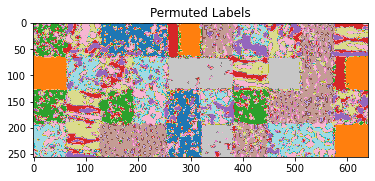

In [11]:
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<p style="background-color:#adebad;">
    Plot the confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, to make them correspond to the true labels (see Hungarian algortihm to find the best match).
</p>

In [12]:
def organize_clusters(HC, predicted_perm_label_map, label_map):
    reward_matrix = np.zeros((HC.n_clusters,HC.n_clusters))
    for predicted_perm_label_map_, label_map_ in zip(predicted_perm_label_map.flatten(),label_map.flatten()):
        reward_matrix[int(predicted_perm_label_map_), int(label_map_)] += 1
    cost_matrix = reward_matrix.max() - reward_matrix
    row_assign, col_assign = linear_sum_assignment(cost_matrix)
    row_assign = row_assign.reshape((-1, 1))
    col_assign = col_assign.reshape((-1, 1))
    assignments = np.concatenate((row_assign, col_assign), axis=1)
    
    predicted_perm_label_map_flat = predicted_perm_label_map.flatten()
    for i in range(predicted_perm_label_map_flat.size):
        if predicted_perm_label_map_flat[i] == assignments[0,0]:
            predicted_perm_label_map_flat[i] = assignments[0,1]
        elif predicted_perm_label_map_flat[i] == assignments[1,0]:
            predicted_perm_label_map_flat[i] = assignments[1,1]
        elif predicted_perm_label_map_flat[i] == assignments[2,0]:
            predicted_perm_label_map_flat[i] = assignments[2,1]
        elif predicted_perm_label_map_flat[i] == assignments[3,0]:
            predicted_perm_label_map_flat[i] = assignments[3,1]
        elif predicted_perm_label_map_flat[i] ==assignments[4,0]:
            predicted_perm_label_map_flat[i] = assignments[4,1]
        elif predicted_perm_label_map_flat[i] == assignments[5,0]:
            predicted_perm_label_map_flat[i] = assignments[5,1]
        elif predicted_perm_label_map_flat[i] == assignments[6,0]:
            predicted_perm_label_map_flat[i] = assignments[6,1]
        elif predicted_perm_label_map_flat[i] == assignments[7,0]:
            predicted_perm_label_map_flat[i] = assignments[7,1]
        elif predicted_perm_label_map_flat[i] == assignments[8,0]:
            predicted_perm_label_map_flat[i] = assignments[8,1]
        elif predicted_perm_label_map_flat[i] == assignments[9,0]:
            predicted_perm_label_map_flat[i] = assignments[9,1]
        
    predicted_perm_label_map = predicted_perm_label_map_flat.reshape(predicted_perm_label_map.shape)
    return predicted_perm_label_map, assignments

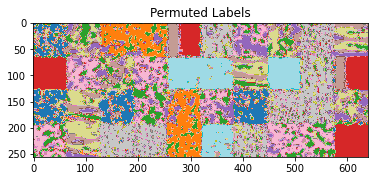

In [13]:
predicted_perm_label_map, assignments = organize_clusters(HC, predicted_perm_label_map, perm_label_map)
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

Text(0.5, 1.0, 'HC Confusion Matrix')

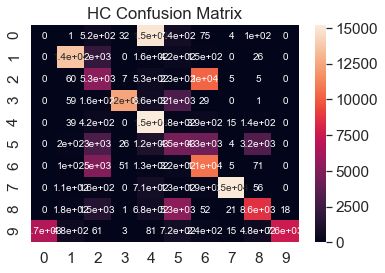

In [36]:

conf_matrix=confusion_matrix(perm_label_map.flatten(), predicted_perm_label_map.flatten())
df = pd.DataFrame(conf_matrix, range(conf_matrix.shape[0]), range(conf_matrix.shape[1]))
sn.set(font_scale=1.4)
sn.heatmap(df, annot=True, annot_kws={"size": 10})
plt.title("HC Confusion Matrix")


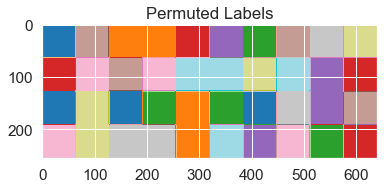

In [15]:
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [16]:
# 3x3 Matrix with accuracy scores of the different parameter combination
d={}
i=0
accuracy_matrix = np.zeros((3,3))
for b_i, bins in enumerate([16,32,64]):
    for w_i, window_size in enumerate([7,9,11]):
        d["HC"+str(i)] = HistogramClustering(n_bins=bins, window_size=window_size)
        d["bins"+str(i)] = bins
        d["wins"+str(i)] = window_size
        
        
        d["HC"+str(i)].fit(texture)
        predicted_perm_label_map = d["HC"+str(i)].predict(perm_texture)
        predicted_perm_label_map, _ = organize_clusters(d["HC"+str(i)], predicted_perm_label_map, perm_label_map)
        check_is_fitted(d["HC"+str(i)], ["centroids"])
        accuracy_matrix[w_i, b_i]=accuracy_score(perm_label_map.flatten(), predicted_perm_label_map.flatten())
        i+=1

Text(26.5, 0.5, 'Window Size')

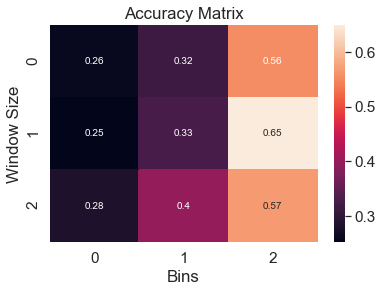

In [17]:

df = pd.DataFrame(accuracy_matrix, range(accuracy_matrix.shape[0]), range(accuracy_matrix.shape[1]))
sn.set(font_scale=1.4)
sn.heatmap(df, annot=True, annot_kws={"size": 10})
plt.title("Accuracy Matrix")
plt.xlabel("Bins")
plt.ylabel("Window Size")


<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them accordingly.
    </p>

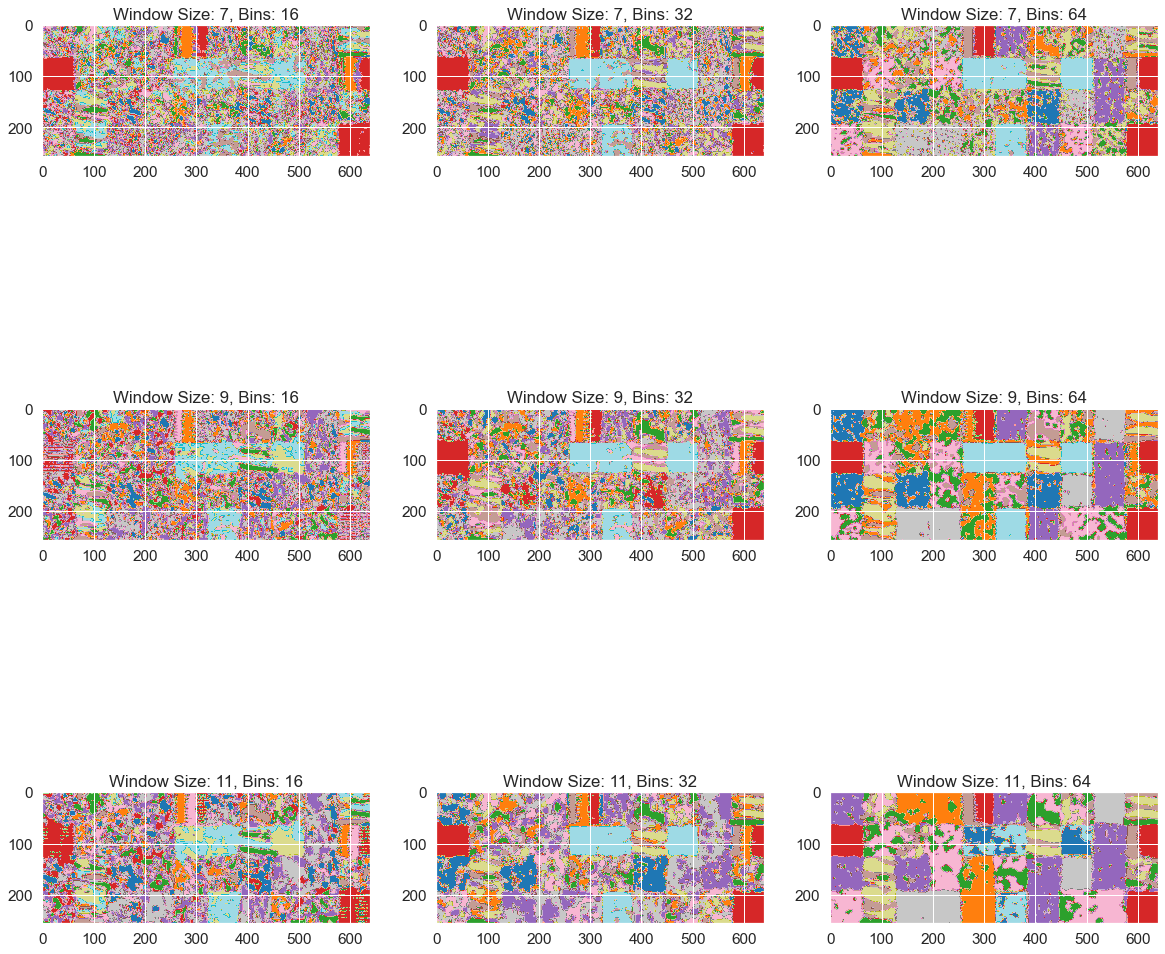

In [19]:
fig, axs = plt.subplots(3, 3)
i=0
fig.set_size_inches(20, 20)
for b_i, bins in enumerate([16,32,64]):
    for w_i, window_size in enumerate([7,9,11]):      
        predicted_perm_label_map = d["HC"+str(i)].predict(perm_texture)
        predicted_perm_label_map,assignments = organize_clusters(d["HC"+str(i)], predicted_perm_label_map, perm_label_map)
        axs[w_i, b_i].imshow(predicted_perm_label_map, cmap="tab20")
        axs[w_i, b_i].set_title("Window Size: " + str(window_size) + ", Bins: " + str(bins))
        i+=1

<h2 style="background-color:#f0b375;">
Section 5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate</b> method for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

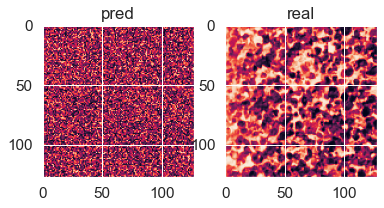

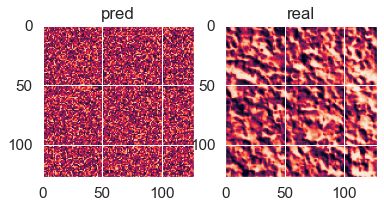

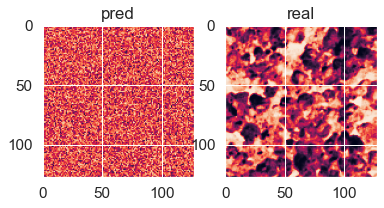

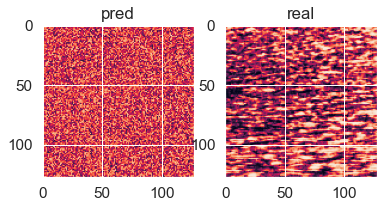

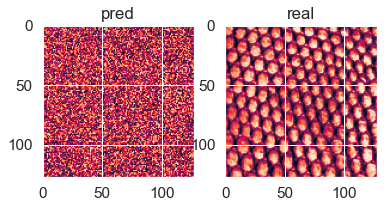

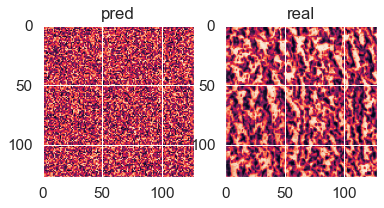

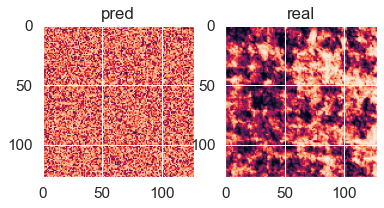

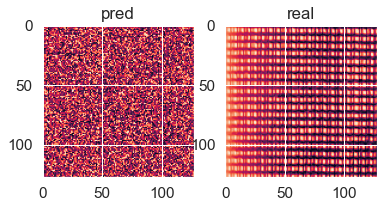

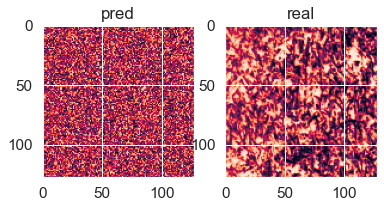

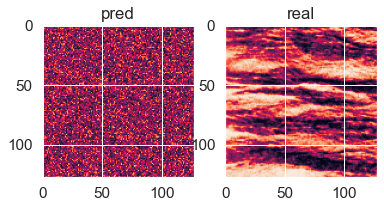

In [29]:
patch_shape = (128,128)
HC = d["HC8"]
patches = []
#fig,axs = plt.subplots(10,2)
for cluster_ in range(HC.n_clusters):
    fig,axs = plt.subplots(1,2)
    cluster = assignments[cluster_, 0]
    cluster_perm = assignments[cluster_, 1]
    C = (np.ones(patch_shape)*cluster).astype(int)
    X = HC.generate(C)

    
    #axs[cluster_, 0].imshow(X)
    #axs[cluster_, 0].set_title("pred")
    #ax1.figure()
    axs[0].imshow(X)
    axs[0].set_title("pred")
    
    
    i, j = np.unravel_index(cluster_perm, patch_grid_shape)
    truth = texture[patch_shape[0] * i:patch_shape[0] * (i + 1), patch_shape[1] * j:patch_shape[1] * (j + 1)]
    

    axs[1].imshow(truth)
    axs[1].set_title("real")
    plt.show()

# C2, C3, etc. You can also use a more suitable data structure to loop over the textures.

# Generated texture plot

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

In [30]:
from sklearn.cluster import KMeans

In [31]:
# Predicted label map for k-means
# Predicted label map for HC
HC = HistogramClustering(n_bins=64, window_size=11)
HC.fit(texture)
kmeans = KMeans(n_clusters = 10)
kmeans.fit(HC.X_patched_bins_flat)
HC_image = HC.predict(perm_texture)
y_kmeans = kmeans.predict(HC.perm_X_patched_bins_flat)
kmeans_image = y_kmeans.reshape(HC_image.shape)

HC_image, _ = organize_clusters(HC, HC_image, perm_label_map)
kmeans_image, _ = organize_clusters(HC, kmeans_image, perm_label_map)

<ul style="background-color:#adebad;">
    <li>
        Plot and compare the confusion matrices for both, k-means, and HC.
    </li>
</ul>

Text(0.5, 1.0, 'Kmeans Confusion Matrix')

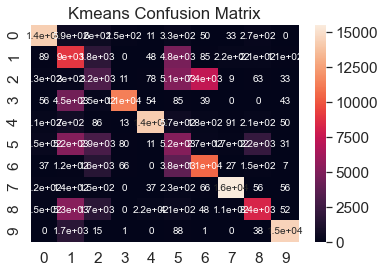

In [32]:
k_confusion = confusion_matrix(perm_label_map.flatten(), kmeans_image.flatten())
df_k = pd.DataFrame(k_confusion, range(k_confusion.shape[0]), range(k_confusion.shape[1]))
sn.set(font_scale=1.4)
sn.heatmap(df_k, annot=True, annot_kws={"size": 10})
#plt.figure(figsize=(2,1))
plt.title("Kmeans Confusion Matrix")


Text(0.5, 1.0, 'HC Confusion Matrix')

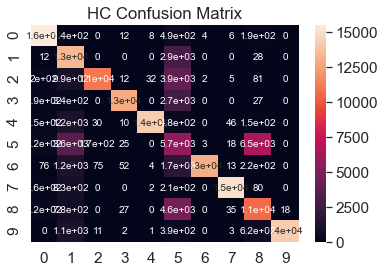

In [33]:
HC_confusion = confusion_matrix(perm_label_map.flatten(), HC_image.flatten())
df_k = pd.DataFrame(HC_confusion, range(HC_confusion.shape[0]), range(HC_confusion.shape[1]))
sn.set(font_scale=1.4)
sn.heatmap(df_k, annot=True, annot_kws={"size": 10})
plt.title("HC Confusion Matrix")

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

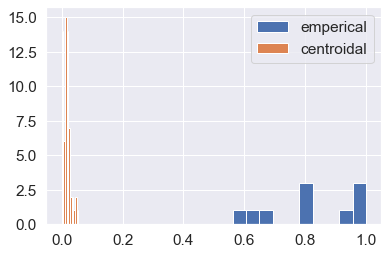

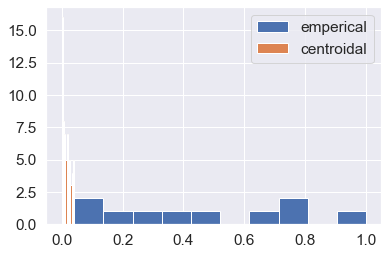

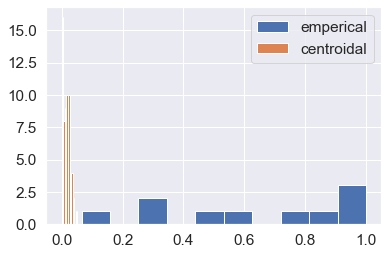

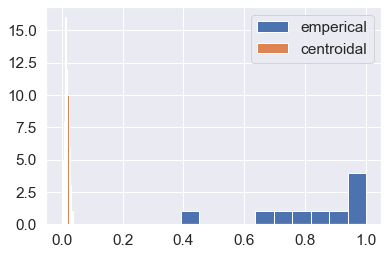

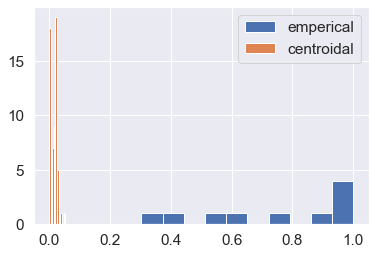

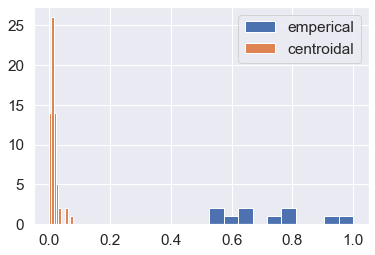

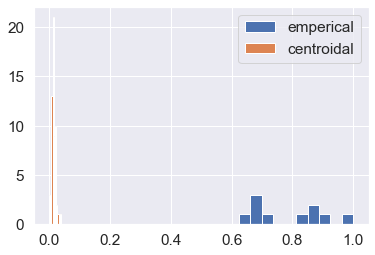

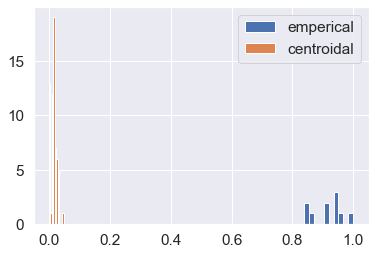

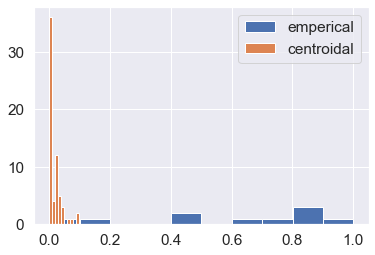

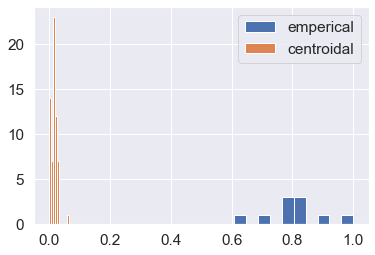

In [34]:
for i in range(HC.centroids.shape[0]):
    
    
    C = (np.ones(patch_shape)*i).astype(int)
    X = HC.generate(C)
    hist,_ = np.histogram(X)
    plt.hist(hist/hist.max(), label="emperical")
    plt.hist(HC.centroids[i,:], label="centroidal")
    plt.legend(loc='upper right')
    
    
    
    plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

In [ ]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. Describe what you observe.
        </li>
    </ul>

In [ ]:
# Clustering at different temperatures

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.